# Delayed Acceptance example: Predator/Prey model

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from scipy.integrate import solve_ivp

import tinyDA as tda

In [78]:
np.random.seed(987)

### Define the predator/prey model
We use scipy.integrate.solve_ivp to solve the predator-prey model. The method `dydx` is the differential equation.

In [79]:
class PredatorPreyModel:
    def __init__(self, datapoints):
        
        # set the timesteps, where we are collecting the model output
        self.datapoints = datapoints
        
        # set the span of the integration.
        self.t_span = [0, self.datapoints[-1]]
        
    def dydx(self, t, y, a, b, c, d):
        # Lotka-Volterra Model model, see e.g. https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations
        return np.array([a*y[0] - b*y[0]*y[1], c*y[0]*y[1] - d*y[1]])

    def __call__(self, parameters):
        # extract the parameters, and take the exponential to keep them positive
        P_0, Q_0, a, b, c, d = np.exp(parameters)
        
        # solve the initial value problem.
        self.y = solve_ivp(lambda t, y: self.dydx(t, y, a, b, c, d), self.t_span, np.array([P_0, Q_0]), t_eval=self.datapoints) 

        # return the results, only if the integration succeeded.
        if self.y.success:
            return self.y.y.flatten(), True
        else:
            return np.zeros_like(self.datapoints), 0


### Set up the true model

In [80]:
# #set the true parameters
P_0 = 10
Q_0 = 5
a = 1.0
b = 0.3
c = 0.2
d = 1.0

# collect the parameters in a vector and take the logarithm. 
# we sample the log of the parameters and take the exponential
# inside the model to keep the parameters positive.
true_parameters = np.log(np.array([P_0, Q_0, a, b, c, d]))

# set the integration points.
t_span = [0,12]
n_eval = 1000
t_eval = np.linspace(t_span[0], t_span[1], n_eval)

# initalise the true model and solve it
my_model = PredatorPreyModel(t_eval)
y_true = my_model(true_parameters)[0]

### Set up the forward models

In [81]:
# fine model
n_data_l2 = 25 # number of datapoints
t_eval_l2 = np.linspace(t_span[0], t_span[1], n_data_l2) # datapoints
my_model_l2 = PredatorPreyModel(t_eval_l2) # initialise model

# coarse model (stops integrating early)
n_data_l1 = 16 # number of datapoints
t_eval_l1 = t_eval_l2[:n_data_l1] # datapoints (the first 16 of the fine model)
my_model_l1 = PredatorPreyModel(t_eval_l1) # initialise model

# coarse model (stops integrating even earlier)
n_data_l0 = 8 # number of datapoints
t_eval_l0 = t_eval_l2[:n_data_l0] # datapoints (the first 8 of the fine model)
my_model_l0 = PredatorPreyModel(t_eval_l0) # initialise model

### Generate data

In [82]:
# set the noise level
sigma = 1.0

noise_l2 = np.random.normal(scale=sigma, size=(t_eval_l2.size,2)) # fine noise
data_l2 = my_model_l2(true_parameters)[0] + np.hstack((noise_l2[:,0], noise_l2[:,1])) # noisy fine data.
data_l2[data_l2 < 0] = 0 # make sure all the data is positive.

noise_l1 = np.hstack((noise_l2[:n_data_l1,0], noise_l2[:n_data_l1,1])) # coarse noise
data_l1 = my_model_l1(true_parameters)[0] + noise_l1 # noisy coarse data
data_l1[data_l1 < 0] = 0 # make sure all the data is positive.

noise_l0 = np.hstack((noise_l2[:n_data_l0,0], noise_l2[:n_data_l0,1])) # coarse noise
data_l0 = my_model_l0(true_parameters)[0] + noise_l0 # noisy coarse data
data_l0[data_l0 < 0] = 0 # make sure all the data is positive

### Plot the true model and the data

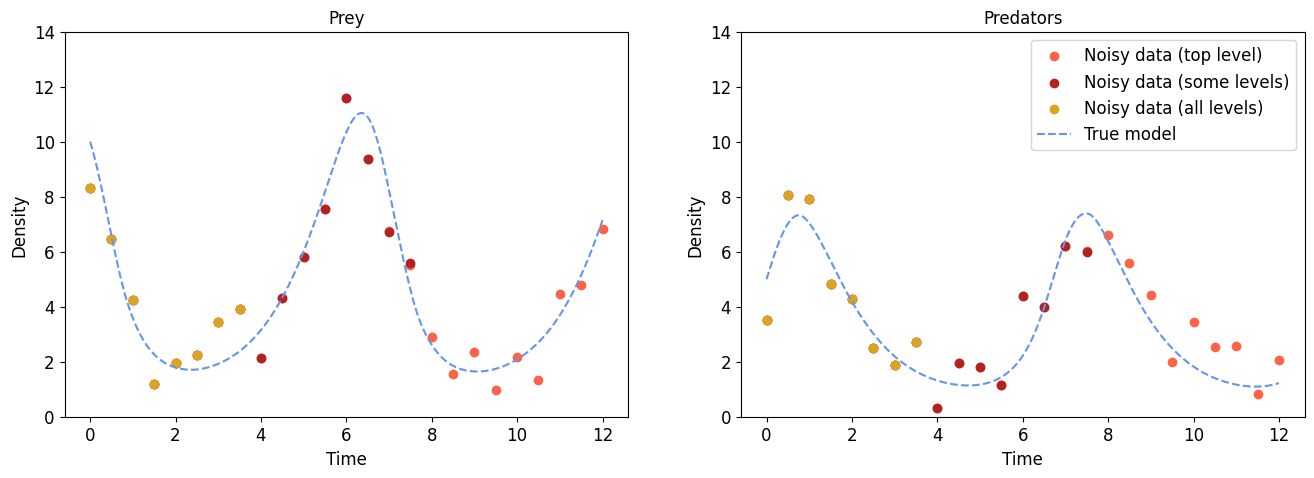

In [83]:
fig, axes = plt.subplots(figsize=(16,5), nrows=1, ncols=2)

axes[0].set_title('Prey', fontsize=12)
axes[0].plot(t_eval, y_true[:n_eval], '--', color='cornflowerblue')
#axes[0].scatter(t_eval_fine, data_fine[:n_data_fine]-noise_fine[:,0], color='cornflowerblue')
axes[0].scatter(t_eval_l2, data_l2[:n_data_l2], color='tomato', label='Noisy data (top level)')
axes[0].scatter(t_eval_l1, data_l1[:n_data_l1], color='firebrick', label='Noisy data (some levels)')
axes[0].scatter(t_eval_l0, data_l0[:n_data_l0], color='goldenrod', label='Noisy data (all levels)')
#axes[0].plot([], [], '--', color='cornflowerblue', label = 'True model')
axes[0].tick_params(axis='both', labelsize=12)
axes[0].set_xlabel('Time', fontsize=12)
axes[0].set_ylim(0, 14); axes[0].set_ylabel('Density', fontsize=12)
#axes[0].legend(loc=2, fontsize=12)

axes[1].set_title('Predators', fontsize=12)
axes[1].plot(t_eval, y_true[n_eval:], '--', color='cornflowerblue')
#axes[1].scatter(t_eval_fine, data_fine[n_data_fine:]-noise_fine[:,1], color='cornflowerblue')
axes[1].scatter(t_eval_l2, data_l2[n_data_l2:], color='tomato', label='Noisy data (top level)')
axes[1].scatter(t_eval_l1, data_l1[n_data_l1:], color='firebrick', label='Noisy data (some levels)')
axes[1].scatter(t_eval_l0, data_l0[n_data_l0:], color='goldenrod', label='Noisy data (all levels)')
axes[1].plot([], [], '--', color='cornflowerblue', label = 'True model')
axes[1].tick_params(axis='both', labelsize=12)
axes[1].set_xlabel('Time', fontsize=12)
axes[1].set_ylim(0, 14); axes[1].set_ylabel('Density', fontsize=12)
axes[1].legend(loc=1, fontsize=12)

plt.show()

### Set up the statistical model  and draw some samples from the prior
We need a fairly well-informed prior, since the model is nonlinear and the data is quite noisy. Hence, we assume that we have pretty good knowledge about the birth- and death rates of the prey and predators, respectively. The predation rate and the growth rate for the predators are left to be fairly uncertain.

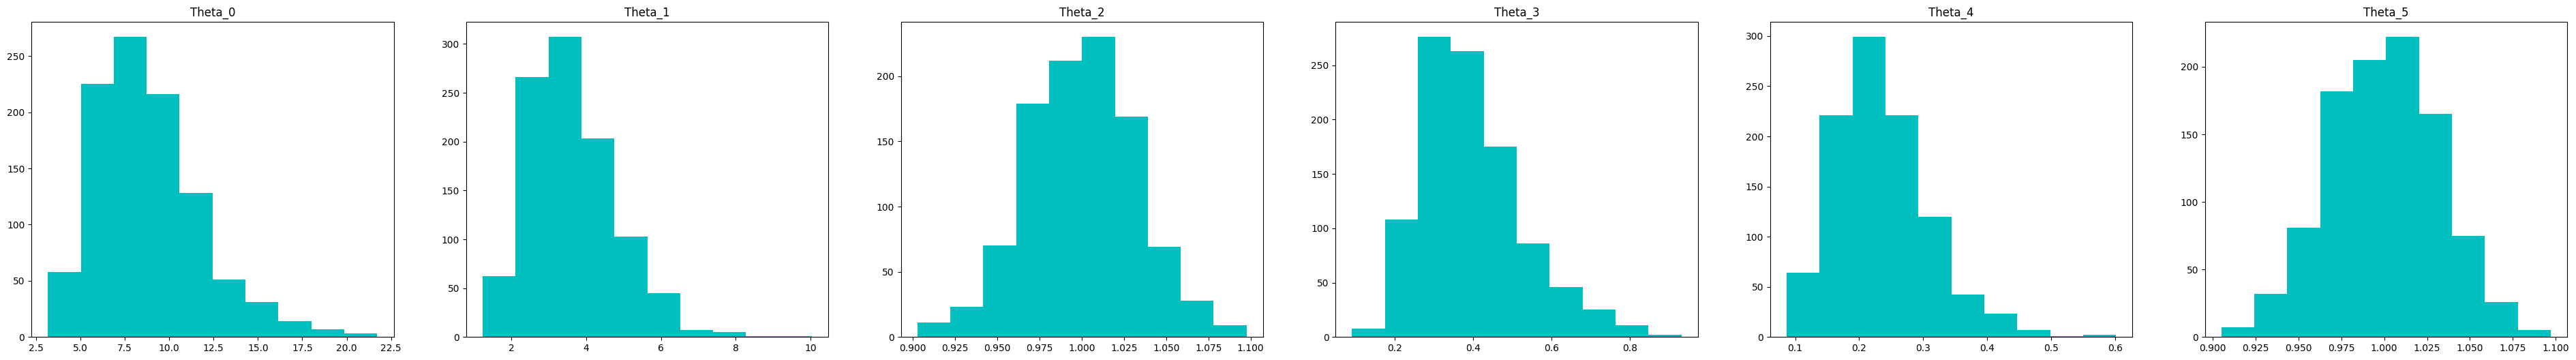

In [84]:
# prior distribution
mean_prior = np.array([np.log(data_l2[0]), np.log(data_l2[n_data_l2]), 0, -1, -1.5, 0])
cov_prior = np.diag([0.1, 0.1, 0.001, 0.1, 0.1, 0.001])
my_prior = stats.multivariate_normal(mean_prior, cov_prior)

# draw some samples and plot them
prior_samples = np.exp(my_prior.rvs(1000))
fig, axes = plt.subplots(nrows=1, ncols=my_prior.dim, figsize = (8*my_prior.dim, 6))
for i in range(my_prior.dim):
    axes[i].set_title('Theta_{}'.format(i))
    axes[i].hist(prior_samples[:,i], color='c')

In [85]:
# define the likelihood
cov_likelihood_l2 = sigma**2*np.eye(data_l2.size)
cov_likelihood_l1 = sigma**2*np.eye(data_l1.size)
cov_likelihood_l0 = sigma**2*np.eye(data_l0.size)

my_loglike_l2 = tda.GaussianLogLike(data_l2, cov_likelihood_l2)
my_loglike_l1 = tda.GaussianLogLike(data_l1, cov_likelihood_l1)
my_loglike_l0 = tda.GaussianLogLike(data_l0, cov_likelihood_l0)

### Set up the link factories and get the MAP point

In [86]:
# set up the link factories
my_posterior_l2 = tda.Posterior(my_prior, my_loglike_l2, my_model_l2)
my_posterior_l1 = tda.Posterior(my_prior, my_loglike_l1, my_model_l1)
my_posterior_l0 = tda.Posterior(my_prior, my_loglike_l0, my_model_l0)

my_posteriors = [my_posterior_l0, my_posterior_l1, my_posterior_l2]

In [87]:
# get the maximum a posteriori point.
MAP = tda.get_MAP(my_posterior_l2)

In [88]:
MAP

array([ 2.19607808,  1.61364208, -0.00844832, -1.25564106, -1.58520006,
       -0.01142963])

### Set up the proposal

In [89]:
# random walk Metropolis
#rwmh_cov = np.eye(6)
#rmwh_scaling = 0.1
#rwmh_adaptive = True
#my_proposal = tda.GaussianRandomWalk(C=rwmh_cov, scaling=rmwh_scaling, adaptive=rwmh_adaptive)

# Adaptive Metropolis
#am_cov = np.eye(true_parameters.size)
#am_t0 = 100
#am_sd = None
#am_epsilon = 1e-6
#am_adaptive = True
#my_proposal = tda.AdaptiveMetropolis(C0=am_cov, t0=am_t0, sd=am_sd, epsilon=am_epsilon)

dream_m0 = 1000
dream_delta = 1
dream_Z_method = 'lhs'
dream_adaptive = True
my_proposal = tda.DREAMZ(M0=dream_m0, delta=dream_delta, Z_method=dream_Z_method, adaptive=dream_adaptive)

### Sample

In [90]:
import os
if "CI" in os.environ:
    iterations = 120
    burnin = 20
else:
    iterations = 2500
    burnin = 500

In [91]:
# initialise the chain
my_chain = tda.sample(my_posteriors, my_proposal, iterations=iterations, n_chains=1, initial_parameters=MAP, subchain_length=10, randomize_subchain_length=True)

Sampling chain 1/1


Running chain, α = 0.54: 100%|██████████| 2500/2500 [11:01<00:00,  3.78it/s]


In [25]:
my_chain['chain_l2_0'][0].parameters

array([ 2.35735858,  1.53646956,  0.00462321, -1.13509361, -1.62172984,
        0.00371912])

In [26]:
my_chain['chain_l2_0'][4].parameters

array([ 2.35735858,  1.53646956,  0.00462321, -1.13509361, -1.62172984,
        0.00371912])

In [137]:
top = extract_parameters(my_chain['chain_l2_0'][burnin:])-extract_parameters(my_chain['promoted_l1_0'][burnin:])
middle = extract_parameters(my_chain['chain_l1_0'])[10*burnin:]-extract_parameters(my_chain['promoted_l0_0'])[10*burnin+1:]

In [167]:
np.mean(extract_parameters(my_chain['chain_l0_0'])[100*burnin:])

2.2629087116373263

In [166]:
np.mean(middle)+np.mean(top)

0.016084847389818663

In [139]:
extract_parameters(my_chain['promoted_l0_0'])

array([2.29432664, 2.29432664, 2.29432664, ..., 2.32300959, 2.32300959,
       2.32300959])

In [163]:
np.mean(extract_parameters(my_chain['chain_l2_0'])[burnin:])

2.2776929680239575

In [159]:
est = np.mean(extract_parameters(my_chain['chain_l0_0'])[100*burnin:])+np.mean(middle)+np.mean(top)

In [164]:
print(est)
print(np.log(10))

2.2789935590271453
2.302585092994046


In [74]:
my_chain['promoted_l0_0'][0].parameters

array([ 2.29036815e+00,  1.73882957e+00, -1.31331027e-02, -1.15145208e+00,
       -1.59718348e+00, -1.55161647e-03])

In [76]:
my_chain['chain_l0_0'][0].parameters

array([ 2.29036815e+00,  1.73882957e+00, -1.31331027e-02, -1.15145208e+00,
       -1.59718348e+00, -1.55161647e-03])

In [84]:
my_chain['chain_l2_0'][7].parameters

array([ 2.29036815,  1.72014794, -0.01756262, -1.15145208, -1.59450066,
       -0.01706791])

In [88]:
my_chain['chain_l2_0'][3].posterior

-13.734487325287848

In [ ]:
np.unique()

In [27]:
accepted = []
last = my_chain['chain_l2_0'][0].parameters[0]
for link in my_chain['chain_l2_0']:
    next = link.parameters[0]
    accepted.append(last-next!=0)
    last = next

In [28]:
np.sum(accepted)

329

In [26]:
len(my_chain['promoted_l0_0'])

1001

In [109]:
def extract_parameters(list):
    output = []
    for element in list:
        output.append(element.parameters.tolist()[0])

    return(np.array(output))

In [ ]:
i=1
for sample in my_chain['promoted_l0_0']:
    print(i)
    print(extract_parameters(my_chain['chain_l1_0'])[i])
    #print(extract_parameters(my_chain['chain_l1_0'])[10*i+sample])
    i+=1

1
[ 2.19530911  1.73953741  0.03322764 -1.14096079 -1.68035861 -0.07162338]
2
[ 2.19530911  1.73953741  0.03322764 -1.14096079 -1.68035861 -0.07162338]
3
[ 2.19530911  1.73953741  0.03322764 -1.2007632  -1.68035861 -0.07162338]
4
[ 2.19530911  1.73953741  0.03322764 -1.2007632  -1.68035861 -0.07162338]
5
[ 2.19530911  1.73953741  0.03322764 -1.2007632  -1.68035861 -0.07162338]
6
[ 2.19530911  1.73953741  0.03322764 -1.2007632  -1.68035861 -0.07162338]
7
[ 2.19530911  1.73953741  0.03322764 -1.2007632  -1.68035861 -0.07162338]
8
[ 2.19530911  1.73953741  0.03322764 -1.2007632  -1.68035861 -0.07162338]
9
[ 2.19530911  1.73953741  0.03322764 -1.2007632  -1.68035861 -0.07162338]
10
[ 2.19530911  1.73953741  0.03322764 -1.2007632  -1.68035861 -0.07162338]
11
[ 2.19530911  1.73953741  0.03322764 -1.2007632  -1.68035861 -0.07162338]
12
[ 2.19530911  1.73953741  0.03322764 -1.2007632  -1.68035861 -0.07162338]
13
[ 2.19530911  1.73953741  0.03322764 -1.2007632  -1.68035861 -0.07162338]
14
[ 2.1

IndexError: index 101 is out of bounds for axis 0 with size 101

In [31]:
extract_parameters(my_chain['chain_l2_0'])

array([[ 2.26628099e+00,  1.47446983e+00,  1.56754706e-02,
        -1.12912960e+00, -1.58820016e+00,  5.19246743e-03],
       [ 2.26628099e+00,  1.47446983e+00,  1.56754706e-02,
        -1.12912960e+00, -1.58820016e+00,  5.19246743e-03],
       [ 2.26628099e+00,  1.47446983e+00,  4.89767161e-03,
        -1.12912960e+00, -1.58820016e+00,  5.19246743e-03],
       [ 2.26628099e+00,  1.47446983e+00,  4.89767161e-03,
        -1.12912960e+00, -1.58820016e+00,  5.19246743e-03],
       [ 2.26628099e+00,  1.47446983e+00,  4.89767161e-03,
        -1.12912960e+00, -1.58820016e+00,  5.19246743e-03],
       [ 2.26628099e+00,  1.47446983e+00,  4.89767161e-03,
        -1.12912960e+00, -1.58820016e+00,  5.19246743e-03],
       [ 2.26628099e+00,  1.47446983e+00,  4.89767161e-03,
        -1.12912960e+00, -1.58820016e+00,  5.19246743e-03],
       [ 2.26628099e+00,  1.47446983e+00,  4.89767161e-03,
        -1.12912960e+00, -1.58820016e+00,  5.19246743e-03],
       [ 2.26628099e+00,  1.47446983e+00,  4.897

In [34]:
len(np.unique(extract_parameters(my_chain['promoted_l0_0'])[:,0]))

AttributeError: 'int' object has no attribute 'parameters'

In [ ]:
def _get_random_proposal_index(subchain_length):
    random_proposal_index = np.random.randint(1-subchain_length, -1)
    return random_proposal_index

In [ ]:
maxi = -1
for i in range(300):
    k = _get_random_proposal_index(40)
    maxi = min(maxi, k)

print(maxi)

-39


In [ ]:
my_chain.keys()

dict_keys(['sampler', 'n_chains', 'iterations', 'levels', 'subchain_lengths', 'randomize_subchain_length', 'chain_l2_0', 'chain_l1_0', 'promoted_l1_0', 'chain_l0_0', 'promoted_l0_0'])

In [83]:
chains = []

In [84]:
chains.append(tda.MLDAChain(my_posteriors, my_proposal, initial_parameters=MAP, subchain_lengths = [10,10], randomize_subchain_length=True))

In [85]:
chains[0].sample(100)

Running chain, α = 0.45: 100%|██████████| 100/100 [00:05<00:00, 17.10it/s]


In [92]:
len(chains[0].proposal.chain)

1101

In [87]:
print(dir(chains[0]))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'accepted', 'adaptive_error_model', 'chain', 'initial_parameters', 'level', 'posterior', 'proposal', 'randomize_subchain_length', 'sample', 'store_coarse_chain', 'subchain_length']


In [93]:
len(chains[0].proposal.proposal.promoted)

1001

In [94]:
sum_accepted = []
for i in range(10):
    for j in range(40):
        sum_accepted.append(sum(chains[0].proposal.proposal.accepted[i*j:i*j+40]))

In [95]:
np.sum(np.array(sum_accepted)==0)

88

In [96]:
chains[0].proposal.proposal.accepted

[True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False

In [124]:
tda.sampler._get_result_mlda(chains, 3, 120, 40, True, True).keys()

dict_keys(['sampler', 'n_chains', 'iterations', 'levels', 'subchain_lengths', 'randomize_subchain_length', 'chain_l2_0', 'chain_l2_1', 'chain_l1_0', 'chain_l1_1', 'promoted_l1_0', 'promoted_l1_1', 'chain_l0_0', 'chain_l0_1', 'promoted_l0_0', 'promoted_l0_1'])

In [44]:
test = []

test.append(test[-1])

test

IndexError: list index out of range

In [104]:
for i in reversed(range(2)):
    print(i)

1
0


### Diagnostics

In [93]:
idata = tda.to_inference_data(my_chain, level=2, burnin=100)

/home/louisekluge/miniconda3/envs/tda/lib/python3.12/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


In [74]:
import arviz as az

In [94]:
az.summary(idata)

arviz - WARNING - Shape validation failed: input_shape: (1, 2401), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,2.196,0.049,2.109,2.300,0.003,0.002,236.0,445.0,NaN
x1,1.600,0.086,1.453,1.761,0.006,0.005,180.0,215.0,NaN
x2,-0.005,0.025,-0.055,0.032,0.002,0.001,217.0,216.0,NaN
x3,-1.242,0.060,-1.361,-1.136,0.004,0.003,221.0,174.0,NaN
x4,-1.580,0.051,-1.677,-1.485,0.003,0.002,314.0,345.0,NaN
x5,-0.010,0.023,-0.054,0.029,0.002,0.001,213.0,95.0,NaN


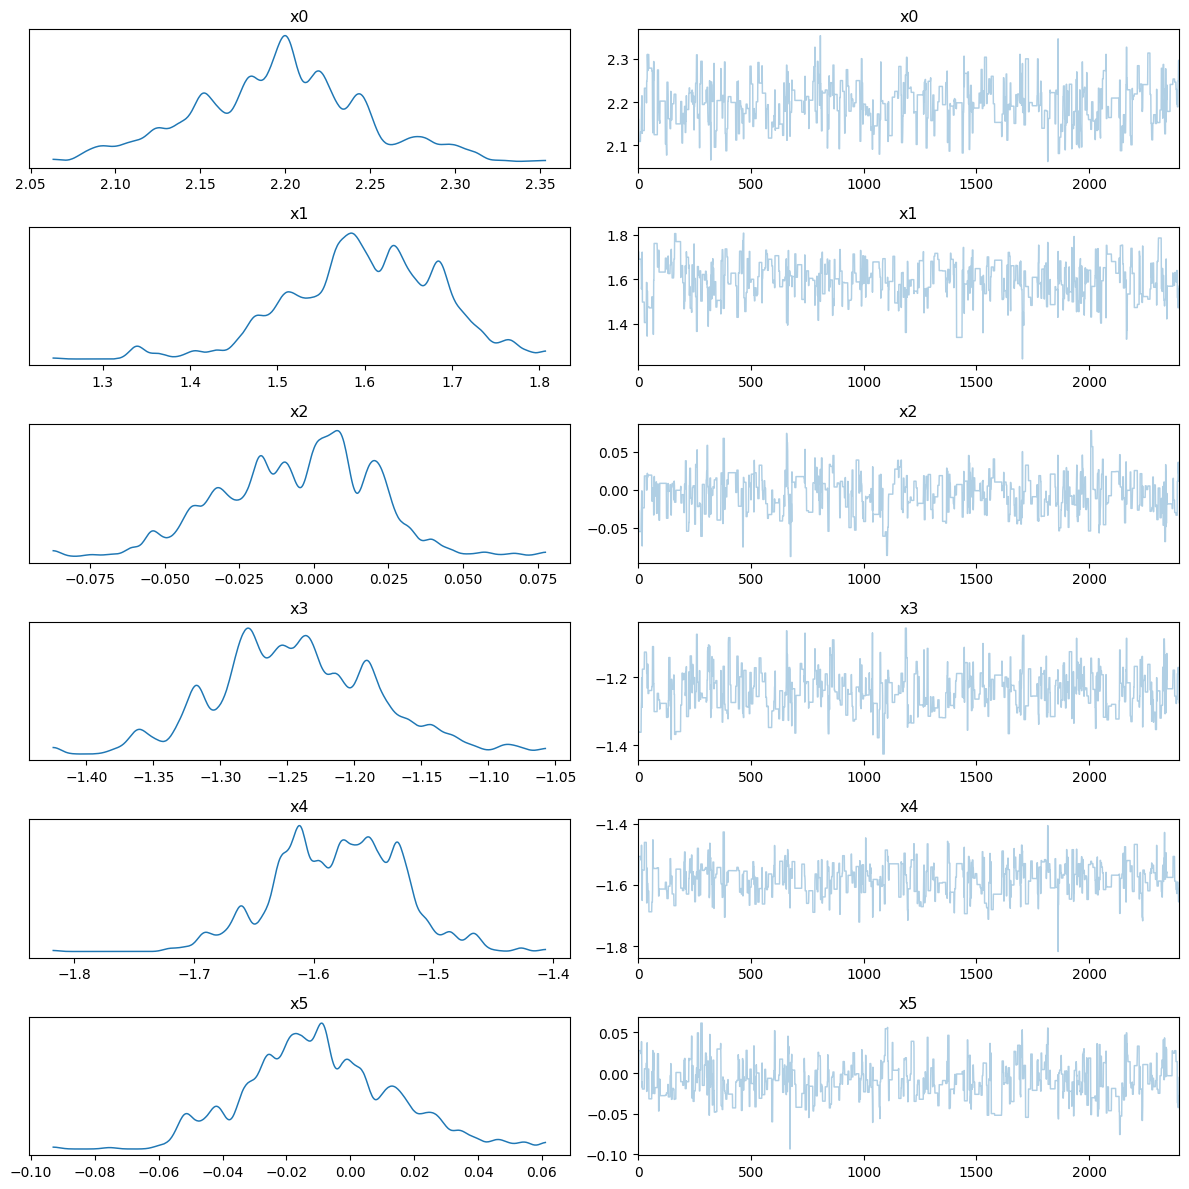

In [95]:
az.plot_trace(idata)
plt.tight_layout()
plt.show()